In [1]:
import numpy as np
import os
import pprint
import tensorflow as tf
from tensorflow.contrib import rnn
from tensorflow import gfile
from tensorflow import logging
import _pickle as pickle
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import glob
import math
from PIL import Image
from subprocess import call
np.random.seed(0)
tf.set_random_seed(1234)

print(tf.__version__)

1.14.0


## 初始化数据文件和输出文件

In [2]:
datasets_dir  = 'datasets'
output_dir = 'output'
if not gfile.Exists(datasets_dir):
    gfile.MakeDirs(datasets_dir)
    
if not gfile.Exists(output_dir):
    gfile.MakeDirs(output_dir)
base_dir = os.path.join(datasets_dir , 'im2txt/')

## 下载数据

In [3]:
!pwd 
os.chdir(datasets_dir)
!pwd && ls 


print("")
print("Downloading...")
if not os.path.exists(base_dir):
    call(
        'wget "https://dikers-data.s3.cn-northwest-1.amazonaws.com.cn/dataset/im2txt.zip"',
        shell=True
    )
    print("Downloading done.\n")
else:
    print("Dataset already downloaded. Did not download twice.\n")


print("Extracting...")
extract_directory = os.path.abspath("im2txt")
if not os.path.exists(extract_directory):
    call(
        'unzip -nq "im2txt.zip"',
        shell=True
    )
    print("Extracting successfully done to {}.".format(extract_directory))
else:
    print("Dataset already extracted. Did not extract twice.\n")


!pwd && ls
os.chdir("..")
!pwd 



/mnt/sdf/workspace/git_hub_demo/learn-rnn
/mnt/sdf/workspace/git_hub_demo/learn-rnn/datasets
anna.txt  cnews  mldata  spa.txt  UCI HAR Dataset  UCI HAR Dataset.zip

Downloading...

Extracting...
Extracting successfully done to /mnt/sdf/workspace/git_hub_demo/learn-rnn/datasets/im2txt.
/mnt/sdf/workspace/git_hub_demo/learn-rnn/datasets
anna.txt  im2txt      mldata   UCI HAR Dataset
cnews	  im2txt.zip  spa.txt  UCI HAR Dataset.zip
/mnt/sdf/workspace/git_hub_demo/learn-rnn


In [4]:
token_file = os.path.join(base_dir  , 'Flickr8k.token.txt')
output_vocab_file = os.path.join(base_dir  , 'vocab.txt')


In [5]:
def count_vocab(token_file):
    with open(token_file, 'r') as f:
        lines = f.readlines()
    
    max_length_of_sentences = 0
    length_dict = {}
    vocab_dict = {}
    
    for line in lines: 
        image_id, description = line.strip('\n').split('\t')
        words = description.strip(' ').split()
        max_length_of_sentences = max(max_length_of_sentences, len(words))
        length_dict.setdefault(len(words), 0)
        length_dict[len(words)] += 1
        
        for word in words: 
            vocab_dict.setdefault(word, 0)
            vocab_dict[word] +=1 
            
    print(max_length_of_sentences)
    pprint.pprint(length_dict)
    return vocab_dict

# 显示每种句子长度的个数
vocab_dict = count_vocab(token_file)

38
{1: 2,
 2: 15,
 3: 47,
 4: 238,
 5: 556,
 6: 1316,
 7: 2711,
 8: 3445,
 9: 3863,
 10: 4307,
 11: 4363,
 12: 4079,
 13: 3649,
 14: 3049,
 15: 2459,
 16: 1791,
 17: 1352,
 18: 956,
 19: 728,
 20: 496,
 21: 329,
 22: 189,
 23: 178,
 24: 112,
 25: 66,
 26: 60,
 27: 30,
 28: 23,
 29: 11,
 30: 11,
 31: 9,
 32: 6,
 33: 3,
 34: 4,
 35: 1,
 38: 1}


In [6]:
sorted_vocab_dict = sorted(vocab_dict.items(), 
                          key = lambda d:d[1], reverse=True)

In [7]:
if not gfile.Exists(output_vocab_file):
    print("vocab 不存在， 新建 {} ".format(output_vocab_file))
    with open(output_vocab_file, 'w') as f:
        f.write("<UNK>\t100000\n")
        for item in sorted_vocab_dict:
            f.write('%s\t%d\n' % item)
else:
    print("vocab 已经存在")

vocab 不存在， 新建 datasets/im2txt/vocab.txt 


## 图片名称和描述读取

In [8]:
model_file = base_dir + 'weight/classify_image_graph_def.pb'
input_description_file = token_file
input_img_dir = base_dir + 'Flicker8k_Dataset'
output_folder = "output/im2txt/feature_extraction_inception_v3"
batch_size = 500
input_img_feature_dir = output_folder

In [9]:
if not gfile.Exists(output_folder):
    gfile.MakeDirs(output_folder)
    
def parse_token_file(token_file):
    img_name_to_tokens = {}
    
    with gfile.GFile(token_file, 'r') as f:
        lines = f.readlines()
        
    for line in lines:
        img_id, description = line.strip('\r\n').split('\t')
        img_name, _ = img_id.split('#')
        img_name_to_tokens.setdefault(img_name, [])
        img_name_to_tokens[img_name].append(description)
    return img_name_to_tokens
  
img_name_to_tokens = parse_token_file(input_description_file)
all_img_names = list(img_name_to_tokens.keys())
logging.info("num of all images: %d" % len(all_img_names))
pprint.pprint(list(img_name_to_tokens.keys())[0:10])
pprint.pprint(img_name_to_tokens['1012212859_01547e3f17.jpg'])

INFO:tensorflow:num of all images: 8091
['1000268201_693b08cb0e.jpg',
 '1001773457_577c3a7d70.jpg',
 '1002674143_1b742ab4b8.jpg',
 '1003163366_44323f5815.jpg',
 '1007129816_e794419615.jpg',
 '1007320043_627395c3d8.jpg',
 '1009434119_febe49276a.jpg',
 '1012212859_01547e3f17.jpg',
 '1015118661_980735411b.jpg',
 '1015584366_dfcec3c85a.jpg']
['A dog shakes its head near the shore , a red ball next to it .',
 'A white dog shakes on the edge of a beach with an orange ball .',
 'Dog with orange ball at feet , stands on shore shaking off water',
 'White dog playing with a red ball on the shore near the water .',
 'White dog with brown ears standing near water with head turned to one side .']


## 显示一张图片

datasets/im2txt/Flicker8k_Dataset/1000268201_693b08cb0e.jpg
['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']


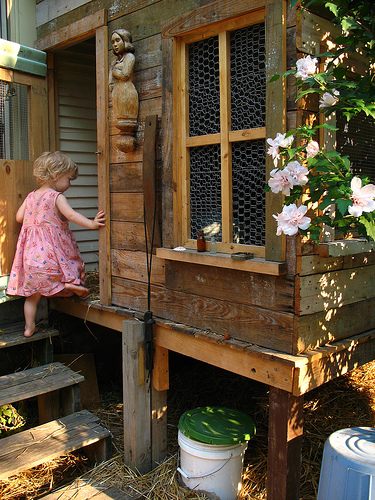

In [27]:
image_name = list(img_name_to_tokens.keys())[0]

print(os.path.join(input_img_dir, image_name))
pprint.pprint(img_name_to_tokens[image_name])
Image.open(os.path.join(input_img_dir, image_name))

## 加载预训练模型

In [10]:
def load_pretrained_inception_v3(model_file):
    with gfile.FastGFile(model_file, 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
        
        _ = tf.import_graph_def(graph_def, name="")
        
load_pretrained_inception_v3(model_file)

Instructions for updating:
Use tf.gfile.GFile.


In [11]:
num_batches = int(len(all_img_names) / batch_size)
if len(all_img_names) % batch_size != 0:
    num_batches += 1

In [12]:
print(num_batches)

17


## 将每张图片的特征提取出来

In [13]:
%%time
if not gfile.Exists(output_folder + 'image_features-0.pickle'):
    with tf.Session() as sess:
        second_to_last_tensor = sess.graph.get_tensor_by_name("pool_3:0")
        for i in range(num_batches):
            batch_img_names = all_img_names[i*batch_size: (i+1)*batch_size]
            batch_features = []

            index = 0 
            for img_name in batch_img_names: 
                index += 1
                img_path = os.path.join(input_img_dir, img_name)
    #             logging.info("processing img %s" % img_name)
                progress =  100.0*index/len(batch_img_names)
                print("\r No{:3d}/{}  progress: {:.2f}% "
                      .format(i, num_batches, progress),end="")
                if not gfile.Exists(img_path):
                    logging.warn("\n%s doesn't exists" % img_path)
                    continue
                img_data = gfile.FastGFile(img_path, "rb").read()
                feature_vector = sess.run(second_to_last_tensor,
                                          feed_dict = {"DecodeJpeg/contents:0": img_data})
                batch_features.append(feature_vector)
            batch_features = np.vstack(batch_features)
            output_filename = os.path.join(output_folder, "image_features-%d.pickle" % i)
            logging.info("\nwriting to file %s" % output_filename)
            with gfile.GFile(output_filename, 'w') as f:
                pickle.dump((batch_img_names, batch_features), f)
else:
    logging.info("图片特征已经提取完成")

 No  0/17  progress: 100.00% INFO:tensorflow:
writing to file output/im2txt/feature_extraction_inception_v3/image_features-0.pickle
 No  1/17  progress: 100.00% INFO:tensorflow:
writing to file output/im2txt/feature_extraction_inception_v3/image_features-1.pickle
 No  2/17  progress: 100.00% INFO:tensorflow:
writing to file output/im2txt/feature_extraction_inception_v3/image_features-2.pickle
 No  3/17  progress: 100.00% INFO:tensorflow:
writing to file output/im2txt/feature_extraction_inception_v3/image_features-3.pickle
 No  4/17  progress: 100.00% INFO:tensorflow:
writing to file output/im2txt/feature_extraction_inception_v3/image_features-4.pickle
 No  5/17  progress: 100.00% INFO:tensorflow:
writing to file output/im2txt/feature_extraction_inception_v3/image_features-5.pickle
 No  6/17  progress: 100.00% INFO:tensorflow:
writing to file output/im2txt/feature_extraction_inception_v3/image_features-6.pickle
 No  7/17  progress: 100.00% INFO:tensorflow:
writing to file output/im2txt/

In [29]:
input_img_feature_dit = output_folder
input_vocab_file = output_vocab_file
output_dir = './output/im2txt/local_run'

if not gfile.Exists(output_dir):
    gfile.MakeDirs(output_dir)
    
def get_default_params():
    return tf.contrib.training.HParams(
        num_vocab_word_threshold = 3, 
        num_embedding_nodes  =32, 
        num_timesteps = 10, 
        num_lstm_nodes = [64, 64], 
        num_lstm_layers = 2, 
        num_fc_nodes = 32, 
        batch_size = 64, 
        cell_type = 'lstm', 
        clip_lstm_grads = 1.0, 
        learning_rate = 0.001, 
        keep_prob = 0.8, 
        log_frequent= 500,
        save_frequent= 2000,
    )
hps = get_default_params()

In [30]:
print(hps)

num_vocab_word_threshold=3,num_embedding_nodes=32,num_timesteps=10,num_lstm_nodes=[64, 64],num_lstm_layers=2,num_fc_nodes=32,batch_size=64,cell_type=lstm,clip_lstm_grads=1.0,learning_rate=0.001,keep_prob=0.8,log_frequent=500,save_frequent=2000


## 封装词表的类

In [31]:
class Vocab(object):
    def __init__(self, filename, word_num_threshold):
        self._id_to_word = {}
        self._word_to_id = {}
        self._unk = -1
        self._eos = -1
        self._word_num_threshold = word_num_threshold
        self._read_dict(filename)
        
    def _read_dict(self, filename):
        with gfile.GFile(filename, 'r') as f:
            lines = f.readlines()
        for line in lines:
            word, occurence = line.strip('\r\n').split('\t')
            occurence = int(occurence)
            if word != '<UNK>' and occurence < self._word_num_threshold:
                continue
            idx = len(self._id_to_word)
            if word == '<UNK>':
                self._unk = idx
            elif word == '.':
                self._eos = idx
            if idx in self._id_to_word or word in self._word_to_id:
                raise Exception('duplicate words in vocab file')
            self._word_to_id[word] = idx
            self._id_to_word[idx] = word
            
            
    @property
    def unk(self):
        return self._unk

    @property
    def eos(self):
        return self._eos

    def word_to_id(self, word):
        return self._word_to_id.get(word, self.unk)

    def id_to_word(self, cur_id):
        return self._id_to_word.get(cur_id, '<UNK>')

    def size(self):
        return len(self._word_to_id)

    def encode(self, sentence):
        word_ids = [self.word_to_id(cur_word) for cur_word in sentence.split(' ')]
        return word_ids

    def decode(self, sentence_id):
        words = [self.id_to_word(word_id) for word_id in sentence_id]
        return ' '.join(words)
    
def parse_token_file(token_file):
    """Parses token file."""
    img_name_to_tokens = {}
    with gfile.GFile(token_file, 'r') as f:
        lines = f.readlines()
    for line in lines:
        img_id, description = line.strip('\r\n').split('\t')
        img_name, _ = img_id.split('#')
        img_name_to_tokens.setdefault(img_name, [])
        img_name_to_tokens[img_name].append(description)
    return img_name_to_tokens

def convert_token_to_id(img_name_to_tokens, vocab):
    """Converts tokens of each description of imgs to id. """
    img_name_to_token_ids = {}
    for img_name in img_name_to_tokens:
        img_name_to_token_ids.setdefault(img_name, [])
        descriptions = img_name_to_tokens[img_name]
        for description in descriptions:
            token_ids = vocab.encode(description)
            img_name_to_token_ids[img_name].append(token_ids)
    return img_name_to_token_ids

In [32]:
vocab = Vocab(input_vocab_file, hps.num_vocab_word_threshold)
vocab_size = vocab.size()
logging.info("vocab_size: %d" % vocab_size)

INFO:tensorflow:vocab_size: 4241


In [33]:
print(vocab.encode('I have a dream .'))

[1720, 549, 1, 0, 2]


In [34]:
print(vocab.decode([23, 14, 333, 35, 200 ]))

wearing white swinging playing high


In [35]:
img_name_to_tokens = parse_token_file(input_description_file)
img_name_to_token_ids = convert_token_to_id(img_name_to_tokens, vocab)

In [36]:
logging.info("num of all images: %d" % len(img_name_to_tokens))
pprint.pprint(list(img_name_to_tokens.keys())[0:3])
pprint.pprint(img_name_to_tokens['1009434119_febe49276a.jpg'])
print('----------------')
logging.info("num of all images: %d" % len(img_name_to_token_ids))
pprint.pprint(list(img_name_to_token_ids.keys())[0:3])
pprint.pprint(img_name_to_token_ids['1009434119_febe49276a.jpg'])

INFO:tensorflow:num of all images: 8091
['1000268201_693b08cb0e.jpg',
 '1001773457_577c3a7d70.jpg',
 '1002674143_1b742ab4b8.jpg']
['A black and white dog is running in a grassy garden surrounded by a white '
 'fence .',
 'A black and white dog is running through the grass .',
 'A Boston terrier is running in the grass .',
 'A Boston Terrier is running on lush green grass in front of a white fence .',
 'A dog runs on the green grass near a wooden fence .']
----------------
INFO:tensorflow:num of all images: 8091
['1000268201_693b08cb0e.jpg',
 '1001773457_577c3a7d70.jpg',
 '1002674143_1b742ab4b8.jpg']
[[3, 15, 8, 14, 9, 7, 33, 4, 1, 127, 681, 278, 55, 1, 14, 179, 2],
 [3, 15, 8, 14, 9, 7, 33, 34, 5, 43, 2],
 [3, 2005, 1184, 7, 33, 4, 5, 43, 2],
 [3, 2005, 2171, 7, 33, 6, 2172, 56, 43, 4, 49, 12, 1, 14, 179, 2],
 [3, 9, 76, 6, 5, 56, 43, 68, 1, 199, 179, 2]]


In [37]:
class ImageCaptionData(object):
    def __init__(self,
                 img_name_to_token_ids,
                 img_feature_dir,
                 num_timesteps,
                 vocab,
                 deterministic = False):
        self._vocab = vocab
        self._all_img_feature_filepaths = []
        for filename in gfile.ListDirectory(img_feature_dir):
            self._all_img_feature_filepaths.append(os.path.join(img_feature_dir, filename))
        pprint.pprint(self._all_img_feature_filepaths)

        self._img_name_to_token_ids = img_name_to_token_ids
        self._num_timesteps = num_timesteps
        self._indicator = 0
        self._deterministic = deterministic
        self._img_feature_filenames = []
        self._img_feature_data = []
        self._load_img_feature_pickle()
        if not self._deterministic:
            self._random_shuffle()


    def _load_img_feature_pickle(self):
        for filepath in self._all_img_feature_filepaths:
            logging.info("loading %s" % filepath)
            with gfile.GFile(filepath, 'rb') as f:
                filenames, features = pickle.load(f, encoding='iso-8859-1')
                self._img_feature_filenames += filenames
                self._img_feature_data.append(features)
        # [(1000, 1, 1, 2048), (1000, 1, 1, 2048)] -> (2000, 1, 1, 2048)       
        self._img_feature_data = np.vstack(self._img_feature_data)
        origin_shape = self._img_feature_data.shape
        self._img_feature_data = np.reshape(
            self._img_feature_data, (origin_shape[0], origin_shape[3]))
        self._img_feature_filenames = np.asarray(self._img_feature_filenames)
#         print(self._img_feature_data.shape)
#         print(self._img_feature_filenames.shape)
        if not self._deterministic:
            self._random_shuffle()


    def size(self):
        return len(self._img_feature_filenames)

    def img_feature_size(self):
        return self._img_feature_data.shape[1]

    def _random_shuffle(self):
        p = np.random.permutation(self.size())
        self._img_feature_filenames = self._img_feature_filenames[p]
        self._img_feature_data = self._img_feature_data[p]

    def _img_desc(self, filenames):
        batch_sentence_ids = []
        batch_weights = []
        for filename in filenames:
            token_ids_set = self._img_name_to_token_ids[filename]
            # chosen_token_ids = random.choice(token_ids_set)
            chosen_token_ids = token_ids_set[0]
            chosen_token_length = len(chosen_token_ids)

            weight = [1 for i in range(chosen_token_length)]
            if chosen_token_length >= self._num_timesteps:
                chosen_token_ids = chosen_token_ids[0:self._num_timesteps]
                weight = weight[0:self._num_timesteps]
            else:
                remaining_length = self._num_timesteps - chosen_token_length
                chosen_token_ids += [self._vocab.eos for i in range(remaining_length)]
                weight += [0 for i in range(remaining_length)]
            batch_sentence_ids.append(chosen_token_ids)
            batch_weights.append(weight)
        batch_sentence_ids = np.asarray(batch_sentence_ids)
        batch_weights = np.asarray(batch_weights)
        return batch_sentence_ids, batch_weights

    def next(self, batch_size):
        end_indicator = self._indicator + batch_size
        if end_indicator > self.size():
            if not self._deterministic:
                self._random_shuffle()
            self._indicator = 0
            end_indicator = self._indicator + batch_size
        assert end_indicator <= self.size()

        batch_img_features = self._img_feature_data[self._indicator: end_indicator]
        batch_img_names = self._img_feature_filenames[self._indicator: end_indicator]
        batch_sentence_ids, batch_weights = self._img_desc(batch_img_names)

        self._indicator = end_indicator
        return batch_img_features, batch_sentence_ids, batch_weights, batch_img_names


caption_data = ImageCaptionData(img_name_to_token_ids, input_img_feature_dir, hps.num_timesteps, vocab)
img_feature_dim = caption_data.img_feature_size()
caption_data_size = caption_data.size()
logging.info("img_feature_dim: %d" % img_feature_dim)
logging.info("caption_data_size: %d" % caption_data_size)



['output/im2txt/feature_extraction_inception_v3/image_features-11.pickle',
 'output/im2txt/feature_extraction_inception_v3/image_features-7.pickle',
 'output/im2txt/feature_extraction_inception_v3/image_features-10.pickle',
 'output/im2txt/feature_extraction_inception_v3/image_features-9.pickle',
 'output/im2txt/feature_extraction_inception_v3/image_features-4.pickle',
 'output/im2txt/feature_extraction_inception_v3/image_features-13.pickle',
 'output/im2txt/feature_extraction_inception_v3/image_features-1.pickle',
 'output/im2txt/feature_extraction_inception_v3/image_features-8.pickle',
 'output/im2txt/feature_extraction_inception_v3/image_features-5.pickle',
 'output/im2txt/feature_extraction_inception_v3/image_features-2.pickle',
 'output/im2txt/feature_extraction_inception_v3/image_features-12.pickle',
 'output/im2txt/feature_extraction_inception_v3/image_features-6.pickle',
 'output/im2txt/feature_extraction_inception_v3/image_features-0.pickle',
 'output/im2txt/feature_extraction

## 打印5个训练数据

In [38]:
batch_img_features, batch_sentence_ids, batch_weights, batch_img_names = caption_data.next(5)
pprint.pprint(batch_img_features)
pprint.pprint(batch_sentence_ids)
pprint.pprint(batch_weights)
pprint.pprint(batch_img_names)

array([[0.18711613, 0.22834839, 0.4485498 , ..., 0.41644758, 0.3622233 ,
        0.13248889],
       [0.04195096, 0.20225167, 0.29569808, ..., 0.24447577, 0.39089605,
        1.1584473 ],
       [0.09007399, 0.19214618, 0.34850267, ..., 0.4281852 , 0.05119258,
        0.26458114],
       [0.828808  , 0.59281796, 1.2272191 , ..., 0.35473815, 0.27108008,
        0.2756827 ],
       [0.21423428, 0.0752472 , 0.16721737, ..., 0.09104942, 0.2060925 ,
        0.4671768 ]], dtype=float32)
array([[   3, 1229,    8, 1939,   16,  283,    1,   26,  928,    2],
       [   3,   20,    4,    1,   26,    8,   15,  176,    7,  195],
       [   3,   11,    6,    5,   66,    7,  253,    1,  146,   12],
       [   3,   11,   10,    1,   14,  601,   18,    1, 1437,  653],
       [ 207,   16,   53,   57,   83,  134,    4,    1, 1369,    2]])
array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1

## 构建计算图

In [39]:
tf.reset_default_graph()
def create_rnn_cell(hidden_dim, cell_type):
    if cell_type == 'lstm':
        return tf.contrib.rnn.BasicLSTMCell(hidden_dim, state_is_tuple=True)
    elif cell_type == 'gru':
        return tf.contrib.rnn.GRUCell(hidden_dim)
    else:
        raise Exception("%s has not been supported" % cell_type)

def dropout(cell, keep_prob):
    return tf.contrib.rnn.DropoutWrapper(cell, output_keep_prob=keep_prob)


def get_train_model(hps, vocab_size, img_feature_dim):
    num_timesteps = hps.num_timesteps
    batch_size = hps.batch_size

    img_feature  = tf.placeholder(tf.float32, (batch_size, img_feature_dim))
    sentence = tf.placeholder(tf.int32, (batch_size, num_timesteps))
    mask = tf.placeholder(tf.float32, (batch_size, num_timesteps))
    keep_prob = tf.placeholder(tf.float32, name='keep_prob')

    global_step = tf.Variable(tf.zeros([], tf.int64), name='global_step', trainable=False)

    # Sets up the embedding layer.
    embedding_initializer = tf.random_uniform_initializer(-1.0, 1.0)
    with tf.variable_scope('embedding', initializer=embedding_initializer):
        embeddings = tf.get_variable(
            'embeddings',
            [vocab_size, hps.num_embedding_nodes],
            tf.float32)
        embed_token_ids = tf.nn.embedding_lookup(embeddings, sentence[:, 0:num_timesteps-1])

    img_feature_embed_init = tf.uniform_unit_scaling_initializer(factor=1.0)
    with tf.variable_scope('image_feature_embed', initializer=img_feature_embed_init):
        embed_img = tf.layers.dense(img_feature, hps.num_embedding_nodes)
        embed_img = tf.expand_dims(embed_img, 1)
        embed_inputs = tf.concat([embed_img, embed_token_ids], axis=1)

    # Sets up LSTM network.
    scale = 1.0 / math.sqrt(hps.num_embedding_nodes + hps.num_lstm_nodes[-1]) / 3.0
    lstm_init = tf.random_uniform_initializer(-scale, scale)
    with tf.variable_scope('lstm_nn', initializer=lstm_init):
        cells = []
        for i in range(hps.num_lstm_layers):
            cell = create_rnn_cell(hps.num_lstm_nodes[i], hps.cell_type)
            cell = dropout(cell, keep_prob)
            cells.append(cell)
        cell = tf.contrib.rnn.MultiRNNCell(cells)

        initial_state = cell.zero_state(hps.batch_size, tf.float32)
        # rnn_outputs: [batch_size, num_timesteps, hps.num_lstm_node[-1]]
        rnn_outputs, _ = tf.nn.dynamic_rnn(cell,
                                           embed_inputs,
                                           initial_state=initial_state)

    # Sets up the fully-connected layer.
    fc_init = tf.uniform_unit_scaling_initializer(factor=1.0)
    with tf.variable_scope('fc', initializer=fc_init):
        rnn_outputs_2d = tf.reshape(rnn_outputs, [-1, hps.num_lstm_nodes[-1]])
        fc1 = tf.layers.dense(rnn_outputs_2d, hps.num_fc_nodes, name='fc1')
        fc1_dropout = tf.contrib.layers.dropout(fc1, keep_prob)
        fc1_dropout = tf.nn.relu(fc1_dropout)
        logits = tf.layers.dense(fc1_dropout, vocab_size, name='logits')

    with tf.variable_scope('loss'):
        sentence_flatten = tf.reshape(sentence, [-1])
        mask_flatten = tf.reshape(mask, [-1])
        mask_sum = tf.reduce_sum(mask_flatten)
        softmax_loss = tf.nn.sparse_softmax_cross_entropy_with_logits(
            logits=logits, labels=sentence_flatten)
        weighted_softmax_loss = tf.multiply(softmax_loss,
                                            tf.cast(mask_flatten, tf.float32))
        prediction = tf.argmax(logits, 1, output_type = tf.int32)
        correct_prediction = tf.equal(prediction, sentence_flatten)
        correct_prediction_with_mask = tf.multiply(
            tf.cast(correct_prediction, tf.float32),
            mask_flatten)
        accuracy = tf.reduce_sum(correct_prediction_with_mask) / mask_sum
        loss = tf.reduce_sum(weighted_softmax_loss) / mask_sum
        tf.summary.scalar('loss', loss)

    with tf.variable_scope('train_op'):
        tvars = tf.trainable_variables()
        for var in tvars:
            logging.info("variable name: %s" % (var.name))
        grads, _ = tf.clip_by_global_norm(
            tf.gradients(loss, tvars), hps.clip_lstm_grads)
        for grad, var in zip(grads, tvars):
            tf.summary.histogram('%s_grad' % (var.name), grad)
        optimizer = tf.train.AdamOptimizer(hps.learning_rate)
        train_op = optimizer.apply_gradients(zip(grads, tvars), global_step=global_step)

    return ((img_feature, sentence, mask, keep_prob),
            (loss, accuracy, train_op),
            global_step)

placeholders, metrics, global_step = get_train_model(hps, vocab_size, img_feature_dim)
img_feature, sentence, mask, keep_prob = placeholders
loss, accuracy, train_op = metrics

summary_op = tf.summary.merge_all()

init_op = tf.global_variables_initializer()
saver = tf.train.Saver(max_to_keep=10)

Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
INFO:tensorflow:variable name: embedding/embeddings:0
INFO:tensorflow:variable name: image_feature_embed/dense/kernel:0
INFO:tensorflow:variable name: image_feature_embed/dense/bias:0
INFO:tensorflow:variable name: lstm_nn/rnn/multi_rnn_cell/cell_0/basic_lstm_cell/kernel:0
INFO:tensorflow:variable name: lstm_nn/rnn/multi_rnn_cell/cell

In [40]:
%%time
training_steps = 20000

with tf.Session() as sess:
    sess.run(init_op)
    writer = tf.summary.FileWriter(output_dir, sess.graph)
    for i in range(training_steps):
        batch_img_features, batch_sentence_ids, batch_weights, _ = caption_data.next(hps.batch_size)
        input_vals = (batch_img_features, batch_sentence_ids, batch_weights, hps.keep_prob)
        
        feed_dict = dict(zip(placeholders, input_vals))
        fetches = [global_step, loss, accuracy, train_op]
        
        should_log = (i + 1) % hps.log_frequent == 0
        should_save = (i + 1) % hps.save_frequent == 0
        if should_log:
            fetches += [summary_op]
        outputs = sess.run(fetches, feed_dict)
        global_step_val, loss_val, accuracy_val = outputs[0:3]
        if should_log:
            summary_str = outputs[4]
            writer.add_summary(summary_str, global_step_val)
            logging.info('Step: %5d, loss: %3.3f, accuracy: %3.3f'
                         % (global_step_val, loss_val, accuracy_val))
        if should_save:
            logging.info("Step: %d, image caption model saved" % (global_step_val))
            saver.save(sess, os.path.join(output_dir, "image_caption"), global_step=global_step_val)

INFO:tensorflow:Step:   499, loss: 3.983, accuracy: 0.298
INFO:tensorflow:Step:   999, loss: 3.777, accuracy: 0.330
INFO:tensorflow:Step:  1499, loss: 3.424, accuracy: 0.348
INFO:tensorflow:Step:  1999, loss: 3.274, accuracy: 0.384
INFO:tensorflow:Step: 1999, image caption model saved
INFO:tensorflow:Step:  2499, loss: 3.501, accuracy: 0.350
INFO:tensorflow:Step:  2999, loss: 3.415, accuracy: 0.334
INFO:tensorflow:Step:  3499, loss: 3.232, accuracy: 0.356
INFO:tensorflow:Step:  3999, loss: 3.067, accuracy: 0.389
INFO:tensorflow:Step: 3999, image caption model saved
INFO:tensorflow:Step:  4499, loss: 2.969, accuracy: 0.397
INFO:tensorflow:Step:  4999, loss: 2.908, accuracy: 0.412
INFO:tensorflow:Step:  5499, loss: 2.857, accuracy: 0.422
INFO:tensorflow:Step:  5999, loss: 2.843, accuracy: 0.400
INFO:tensorflow:Step: 5999, image caption model saved
INFO:tensorflow:Step:  6499, loss: 2.748, accuracy: 0.452
INFO:tensorflow:Step:  6999, loss: 2.872, accuracy: 0.414
INFO:tensorflow:Step:  749